## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## **Importing the necessary libraries**

In [ ]:
# Libraries for data loading, data viz and EDA
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Libraries for text preprocessing and analysis
import re,nltk,spacy,string
nlp=spacy.load("en_core_web_sm")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

# Libraries for model evaluation metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# row/column display limit
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
# MOUNT drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Loading the data**

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
# Opening JSON file
f = open('/content/drive/MyDrive/TC/complaints-2021-05-14_08_16.json')

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## **Data preparation**

In [ ]:
# Inspect the dataframe to understand the given data.
df.head(3)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [ ]:
#print the column names
columns=df.columns
print(columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state',
       '_source.consumer_disputed', '_source.product', '_source.company_response',
       '_source.company', '_source.submitted_via', '_source.date_sent_to_company',
       '_source.company_public_response', '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [ ]:
#Assign new column names
# let us convert all _source.columnname to columnname
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code',
       'complaint_id', 'issue', 'date_received', 'state',
       'consumer_disputed', 'product', 'company_response',
       'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue',
       'consumer_consent_provided']

df.head(1)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided


In [ ]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace('', np.nan, regex=True)



In [ ]:
df['complaint_what_happened'].isnull().sum()

57241

In [ ]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'],inplace=True)

In [ ]:

df['complaint_what_happened'].isnull().sum()
# we can see 0 NaN values

0

In [ ]:
df.head(3)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",Information belongs to someone else,Consent provided


## **Prepare the text for topic modeling**

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [ ]:
# Write your function here to clean the text and remove all the unnecessary elements.

def clean_texts(text):
    #Make the text lowercase
    text=text.lower()

    #Remove text in square brackets
    text=re.sub(r'\[.*?\]','',text)

    #Remove punctuation
    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)

    #Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)

     # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)

    # Remove masks XXXX  from the text
    text = text.replace('xxxx','')

    return text


In [ ]:
df['complaint_clean'] = df['complaint_what_happened'].apply(lambda x: clean_texts(x))

In [ ]:
df.head(3)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,complaint_clean
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",Information belongs to someone else,Consent provided,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant


In [ ]:
#Write your function to Lemmatize the texts
def lemmatizer(texts):
   # Initialize empty list to store lemmas
    lemma_list = []


    # Extract lemmas of given text and add to the list 'sent'
    document = nlp(texts)
    for word in document:
        lemma_list.append(word.lemma_)

    # return string converted form of the list of lemmas
    return " ".join(lemma_list)

In [ ]:
df["complaint_lemma"] =  df.apply(lambda x: lemmatizer(x['complaint_clean']), axis=1)

In [ ]:
df['complaint_lemma'].head(1)

,complaint_lemma
1,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account thank in advance for your help


In [ ]:
# we can see  after lemmatization, the lowercase i became I, lets change it back to lowercase
df['complaint_lemma'] = df['complaint_lemma'].str.lower()
df['complaint_lemma'].head(1)

,complaint_lemma
1,good morning my name be and i appreciate it if you could help i put a stop to chase bank cardmember service in i write to chase ask for debt verification and what they send i a statement which be not acceptable i be ask the bank to validate the debt instead i been receive mail every month from they attempt to collect a debt i have a right to know this information as a consumer chase account thank in advance for your help


In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean=df[['complaint_what_happened','complaint_lemma']]


In [ ]:
df_clean.head(3)

,complaint_what_happened,complaint_lemma
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name be and i appreciate it if you could help i put a stop to chase bank cardmember service in i write to chase ask for debt verification and what they send i a statement which be not acceptable i be ask the bank to validate the debt instead i been receive mail every month from they attempt to collect a debt i have a right to know this information as a consumer chase account thank in advance for your help
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give i the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead i
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant


In [ ]:
df_clean.shape

(21072, 2)

In [ ]:
df_backup = df_clean

In [ ]:
#Write your function to extract the POS tags and remove tags other than NN

def NN_tags(text):
    # Process the text with spaCy
    doc = nlp(text)
    # Extract words with 'NOUN' POS tag and singular form(NN)
    return ' '.join([token.text for token in doc if token.pos_ == "NOUN" and token.tag_ == "NN"])




df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: NN_tags(x['complaint_lemma']), axis=1)


In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(3)

,complaint_what_happened,complaint_lemma,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name be and i appreciate it if you could help i put a stop to chase bank cardmember service in i write to chase ask for debt verification and what they send i a statement which be not acceptable i be ask the bank to validate the debt instead i been receive mail every month from they attempt to collect a debt i have a right to know this information as a consumer chase account thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account advance help
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give i the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead i,card agent anniversary date agent information order account anniversary date consent recording agent
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card report application identity consent service credit identity applicant


## **Exploratory data analysis to get familiar with the data.**

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




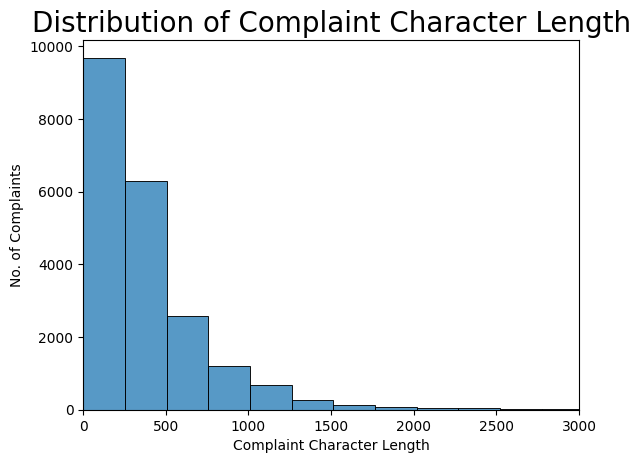

In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length

#creating a list to store the characters of each row
l = [len(x) for x in df_clean['complaint_POS_removed']]

#using the list as data to plot a seaborn histplot
sns.histplot(data=l, bins=50)
plt.xlim(0, 3000)  # Set x-axis range from 0 to 3000
plt.title('Distribution of Complaint Character Length', fontsize=20)
plt.xlabel('Complaint Character Length',size=10)
plt.ylabel('No. of Complaints',size=10)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

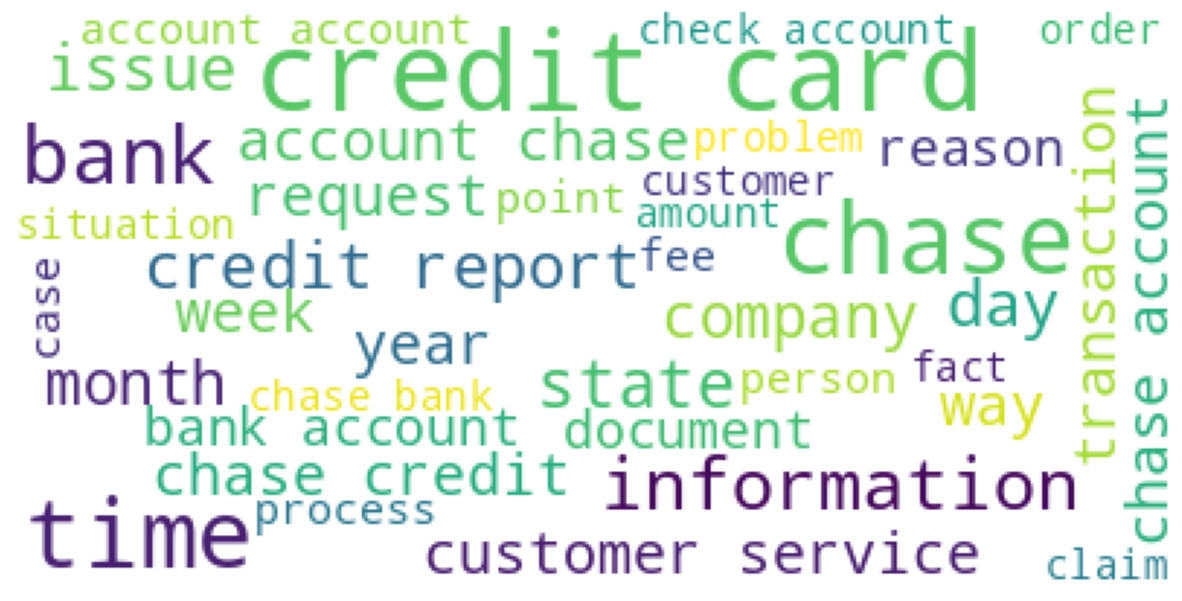

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

stop_words = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_font_size=38,
                          max_words=38,
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(15,10))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()



In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean.drop(columns= 'complaint_POS_removed',inplace = True)


In [ ]:

df_clean.head(3)

,complaint_what_happened,complaint_lemma,Complaint_clean
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name be and i appreciate it if you could help i put a stop to chase bank cardmember service in i write to chase ask for debt verification and what they send i a statement which be not acceptable i be ask the bank to validate the debt instead i been receive mail every month from they attempt to collect a debt i have a right to know this information as a consumer chase account thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account advance help
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give i the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead i,card agent anniversary date agent information order account anniversary date consent recording agent
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card report application identity consent service credit identity applicant


In [ ]:

df_clean.shape

(21072, 3)

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_unigram(text, n=30):

    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [ ]:
#Print the top 10 words in the unigram frequency
top_common_words = get_top_unigram(df_clean['Complaint_clean'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
df_unigram.head(10)

,unigram,count
0,chase,54859
1,account,47500
2,credit,33532
3,card,30326
4,bank,22321
5,payment,21153
6,time,16020
7,charge,14251
8,day,13174
9,check,12295


In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_bigram(text, n=30):

    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [ ]:
#Print the top 10 words in the bigram frequency

top_common_words = get_top_bigram(df_clean['Complaint_clean'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])
df_bigram.head(10)

,bigram,count
0,credit card,12864
1,credit report,3942
2,account chase,3177
3,customer service,3074
4,chase credit,3044
5,chase account,2781
6,account account,2584
7,bank account,2547
8,check account,2376
9,chase bank,2147


In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_trigram(text, n=30):

    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [ ]:
#Print the top 10 words in the trigram frequency

top_common_words = get_top_trigram(df_clean['Complaint_clean'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
df_trigram.head(10)

,trigram,count
0,chase credit card,2028
1,credit card account,1115
2,credit card company,990
3,credit card chase,773
4,credit card credit,548
5,inquiry credit report,523
6,account credit card,449
7,charge credit card,421
8,card credit card,421
9,chase customer service,411


 The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
#All masked texts has been removed
df_clean.head(3)

,complaint_what_happened,complaint_lemma,Complaint_clean
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name be and i appreciate it if you could help i put a stop to chase bank cardmember service in i write to chase ask for debt verification and what they send i a statement which be not acceptable i be ask the bank to validate the debt instead i been receive mail every month from they attempt to collect a debt i have a right to know this information as a consumer chase account thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account advance help
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give i the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead i,card agent anniversary date agent information order account anniversary date consent recording agent
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card report application identity consent service credit identity applicant


## **Feature Extraction**
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
df_clean.shape

(21072, 3)

In [ ]:
#Write your code here to initialise the TfidfVectorizer

tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm=tfidf.fit_transform(df_clean['Complaint_clean'])


In [ ]:
df_clean.shape

(21072, 3)

## **Topic Modelling using NMF**

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## **Manual Topic Modeling**
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [ ]:
nmf_model.fit(dtm)
feature_names = tfidf.get_feature_names_out()
len(feature_names)

6957

In [ ]:
#Print the Top15 words for each of the topics

for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

TOP 15 WORDS FOR TOPIC #0
['customer', 'transaction', 'transfer', 'business', 'number', 'checking', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']


TOP 15 WORDS FOR TOPIC #1
['service', 'time', 'application', 'purchase', 'offer', 'month', 'point', 'year', 'score', 'limit', 'account', 'balance', 'chase', 'credit', 'card']


TOP 15 WORDS FOR TOPIC #2
['day', 'date', 'statement', 'balance', 'property', 'rate', 'year', 'time', 'modification', 'month', 'home', 'chase', 'mortgage', 'loan', 'payment']


TOP 15 WORDS FOR TOPIC #3
['file', 'inquire', 'date', 'letter', 'score', 'theft', 'identity', 'account', 'debt', 'reporting', 'company', 'information', 'credit', 'inquiry', 'report']


TOP 15 WORDS FOR TOPIC #4
['day', 'company', 'time', 'refund', 'service', 'email', 'purchase', 'fraud', 'claim', 'merchant', 'fee', 'transaction', 'chase', 'dispute', 'charge']




In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_result = nmf_model.transform(dtm)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)



array([0, 1, 3, ..., 4, 1, 2])

In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_result.argmax(axis=1) #write your code to assign topics to each rows.#write your code to assign topics to each rows.

In [ ]:
df_clean.shape

(21072, 4)

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_grp =  df_clean.groupby('Topic').head(5)
df_grp.sort_values('Topic')


,complaint_what_happened,complaint_lemma,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name be and i appreciate it if you could help i put a stop to chase bank cardmember service in i write to chase ask for debt verification and what they send i a statement which be not acceptable i be ask the bank to validate the debt instead i been receive mail every month from they attempt to collect a debt i have a right to know this information as a consumer chase account thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account advance help,0
24,mishandling of this account by Chase auto and XXXX.,mishandle of this account by chase auto and,mishandle account chase auto,0
17,"With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative that my account would actually be closed. I went into the branch to see how I can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. The bank associate and the customer service representative assured me that the funds would Post but they may take an additional business day. That Saturday I attempted to go inside of a branch yet again to retrieve my funds that actually did post on Friday, XX/XX/2019. Upon looking at my account I realize that the funds have been reversed and no longer were present on my current statement. Ive been called and I was told that it may take two business day stating Tuesday, XX/XX/XXXX would be the date that my funds would be available to withdraw from a bank teller only. Now, Chase is informing me that I will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently. Unfortunately, This has put me in an additional financial bind do two fees from late rent late car payments, etc. I am not being a short or giving written notice that these things will actually occur so that I have peace of mind in fact Chase has handled my situation grossly I even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. Although I know that Chase reserves the right to close my account at any time I do believe that their protocol has been in the past to give notice in the form of a written document. I am not being a shored or giving written notice that these things will actually occur so that I have peace of mind in fact Chase has handled my situation grossly I even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. Although I know that Chase reserves the right to close my account at any time I do believe that their protocol has been in the past to give notice in the form of a written document. This situation is truly affecting my livelihood and they dont seem to want to deal with Me professionally. Thank you",with out notice jp morgan chase restrict my account by my debit card tuesday on thursday i go into a branch after be advise by a customer service representative that my account would actually be close i go into the branch to see how i can remove the fund that be in there currently in as well as if my direct deposit from my place of employment would be return the bank associate and the customer service representative assure i that the fund would p

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
df_clean.shape

(21072, 4)

In [ ]:
#Create the dictionary of Topic names and Topics

#Create the dictionary of Topic names and Topics
# #Replace Topics with Topic Names
df_clean.replace({'Topic':{0:"Bank Account services",
               1:"Credit card or prepaid card",
               2:"Mortgage/Loan",
               3:"Others",
               4:"Theft/Dispute Reporting"}},inplace=True)

df_clean.shape

(21072, 4)

In [ ]:
df_clean.head(5)

,complaint_what_happened,complaint_lemma,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name be and i appreciate it if you could help i put a stop to chase bank cardmember service in i write to chase ask for debt verification and what they send i a statement which be not acceptable i be ask the bank to validate the debt instead i been receive mail every month from they attempt to collect a debt i have a right to know this information as a consumer chase account thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account advance help,Bank Account services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give i the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead i,card agent anniversary date agent information order account anniversary date consent recording agent,Credit card or prepaid card
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card report application identity consent service credit identity applicant,Others
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",on while try to book a ticket i come across an off

## **Supervised model to predict any new complaints to the relevant Topics.**

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

df_clean.replace({'Topic':{"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Mortgage/Loan":2,
               "Others":3,
               "Theft/Dispute Reporting":4}},inplace=True)
df_clean.shape

(21072, 4)

In [ ]:
df_clean.head()

,complaint_what_happened,complaint_lemma,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name be and i appreciate it if you could help i put a stop to chase bank cardmember service in i write to chase ask for debt verification and what they send i a statement which be not acceptable i be ask the bank to validate the debt instead i been receive mail every month from they attempt to collect a debt i have a right to know this information as a consumer chase account thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account advance help,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give i the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead i,card agent anniversary date agent information order account anniversary date consent recording agent,1
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card report application identity consent service credit identity applicant,3
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",on while try to book a ticket i come across an offer for to be apply towards the ticket if i apply fo

In [ ]:
df_clean.shape

(21072, 4)

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [ ]:
training_data.shape

(21072, 2)

## **Apply the supervised models on the training data created. In this process, you have to do the following:**
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count
count_vector=CountVectorizer()

#Write your code here to transform the word vector to tf-idf
X_train_count=count_vector.fit_transform(training_data['complaint_what_happened'])



In [ ]:

tfidf_transform= TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(X_train_count)

In [ ]:

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (15804, 29725)
y_train Shape: (15804,)
X_test Shape: (5268, 29725)
y_test Shape: (5268,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Create a function to evaluate models
def model_eval(y_test, y_pred, model_name):

    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))



    return


In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# **Model:1 - Logistic Regression**

In [ ]:
# Import required library
from sklearn.linear_model import LogisticRegression

In [ ]:
# Run the Logistic Regression model with default parameters
model_name = 'LOGISTIC REGRESSION'
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [ ]:
# Hyperparameter tuning for best result
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100]
}

grid_lr = GridSearchCV(estimator=lr,
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'C': 10, 'penalty': 'l2'}


In [ ]:
# Creating model with best hyperparameter
lr_tuned = LogisticRegression(C=10,
                                  penalty='l2'
                                   )

lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)

In [ ]:
# Calculate F1 Score of tuned model using weighted average method
f1_lr = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr

0.9129598608027387

In [ ]:
# Evaluate the tuned Logistic Regression classifier
model_eval(y_test, y_pred_lr_tuned, model_name)

CLASSIFICATION REPORT for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account services       0.92      0.91      0.92      1308
Credit card or prepaid card       0.93      0.91      0.92      1043
                     Others       0.94      0.95      0.94      1265
    Theft/Dispute Reporting       0.91      0.88      0.89       560
              Mortgage/Loan       0.86      0.89      0.88      1092

                   accuracy                           0.91      5268
                  macro avg       0.91      0.91      0.91      5268
               weighted avg       0.91      0.91      0.91      5268



# **Model 2 : Decission Tree**

In [ ]:
# Import required library
from sklearn.tree import DecisionTreeClassifier





In [ ]:
# Run Decision Tree with default hyperparameters
model_name = 'DECISION TREE'
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt =dt.predict(X_test)

In [ ]:
# Hyperparameter tuning for best result
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],

}

grid_dt = GridSearchCV(estimator=dt,
                       param_grid=param_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 15}


In [ ]:
# Creating model with best hyperparameter
dt_tuned = DecisionTreeClassifier(criterion='gini',
                                      max_depth=25,
                                      min_samples_leaf=15,
                                      )
dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)

In [ ]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt

0.7745782553158075

In [ ]:

# Evaluate the tuned Decision Tree classifier
model_eval(y_test, y_pred_dt_tuned, model_name)

CLASSIFICATION REPORT for DECISION TREE

                             precision    recall  f1-score   support

      Bank Account services       0.79      0.80      0.79      1308
Credit card or prepaid card       0.75      0.80      0.78      1043
                     Others       0.85      0.83      0.84      1265
    Theft/Dispute Reporting       0.78      0.69      0.73       560
              Mortgage/Loan       0.69      0.70      0.70      1092

                   accuracy                           0.77      5268
                  macro avg       0.77      0.76      0.77      5268
               weighted avg       0.78      0.77      0.77      5268



# **Model 3 : Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Run the Logistic Regression model with default parameters
model_name = 'RANDOM FOREST'
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)

y_pred_rfc = rfc.predict(X_test)

In [ ]:
# Calculate F1 Score of tuned model using weighted average method
f1_rfc = f1_score(y_test, y_pred_rfc, average="weighted")
f1_rfc

0.6894418612014146

In [ ]:
# Evaluate the tuned Logistic Regression classifier
model_eval(y_test, y_pred_rfc, model_name)

CLASSIFICATION REPORT for RANDOM FOREST

                             precision    recall  f1-score   support

      Bank Account services       0.67      0.92      0.78      1308
Credit card or prepaid card       0.79      0.49      0.61      1043
                     Others       0.67      0.91      0.77      1265
    Theft/Dispute Reporting       0.97      0.29      0.44       560
              Mortgage/Loan       0.75      0.65      0.70      1092

                   accuracy                           0.71      5268
                  macro avg       0.77      0.65      0.66      5268
               weighted avg       0.74      0.71      0.69      5268



**As per the F1 score of all the 3 models, Logistic Regression performs best with F1 score : 0.91**

We will use Logistic regression model to predict topic for some custom texts

In [ ]:
# Create a dataframe of some sample customer complaints
df_custom = pd.DataFrame({'complaints': [
    "I want to know the status of my savings account application. It's been over a week since I submitted the documents.",
    "I was charged a late fee on my credit card even though I made the payment on time. Please correct this mistake.",
    "I need details on how to refinance my existing home loan and the current interest rates available.",
    "I visited the branch today and the staff refused to help me with my inquiry. Highly dissatisfied with the service.",
    "An unauthorized transaction of $500 was made on my card. I need immediate assistance in blocking my card.",
    "Please provide the documentation required to close my current account at your branch.",
    "I received a message saying my card was blocked due to suspicious activity. What should I do next?",
], })
df_custom

,complaints
0,I want to know the status of my savings account application. It's been over a week since I submitted the documents.
1,I was charged a late fee on my credit card even though I made the payment on time. Please correct this mistake.
2,I need details on how to refinance my existing home loan and the current interest rates available.
3,I visited the branch today and the staff refused to help me with my inquiry. Highly dissatisfied with the service.
4,An unauthorized transaction of $500 was made on my card. I need immediate assistance in blocking my card.
5,Please provide the documentation required to close my current account at your branch.
6,I received a message saying my card was blocked due to suspicious activity. What should I do next?


In [ ]:
# we will usr the preprocessing functions for our custom texts so that we can do predictions


df_custom['complaints_clean'] = df_custom['complaints'].apply(lambda x: clean_texts(x))

df_custom["complaints_clean"] =  df_custom.apply(lambda x: lemmatizer(x['complaints_clean']), axis=1)

df_custom["complaints_clean"] =  df_custom.apply(lambda x: NN_tags(x['complaints_clean']), axis=1)



In [ ]:
df_custom

,complaints,complaints_clean
0,I want to know the status of my savings account application. It's been over a week since I submitted the documents.,status account application be week document
1,I was charged a late fee on my credit card even though I made the payment on time. Please correct this mistake.,fee credit card payment time mistake
2,I need details on how to refinance my existing home loan and the current interest rates available.,detail exist home loan interest rate
3,I visited the branch today and the staff refused to help me with my inquiry. Highly dissatisfied with the service.,branch today staff inquiry service
4,An unauthorized transaction of $500 was made on my card. I need immediate assistance in blocking my card.,transaction card assistance block card
5,Please provide the documentation required to close my current account at your branch.,documentation account branch
6,I received a message saying my card was blocked due to suspicious activity. What should I do next?,message card block activity


In [ ]:
# let us create X_test_custom for out custom test

# we will use both the count_vectorizer object and tfidf object to transform our custom text
X_test_custom = tfidf_transform.transform(count_vector.transform(df_custom['complaints_clean']))

# let us now use our Logistic regression model object : lr_tuned  to predict the X_test_custom created
y_pred_custom = lr_tuned.predict(X_test_custom)

# add these predictions to the dataframe
df_custom['predicted_topic'] = y_pred_custom


# now let us use the dictionary of topics to map the number to topic names

df_custom.replace({'predicted_topic':{0:"Bank Account services",
               1:"Credit card or prepaid card",
               2:"Mortgage/Loan",
               3:"Others",
               4:"Theft/Dispute Reporting"}},inplace=True)

# drop the complaints_clean column so as to visualize predictions clearly
df_custom.drop(columns = 'complaints_clean', inplace = True)

#visualize
df_custom


,complaints,predicted_topic
0,I want to know the status of my savings account application. It's been over a week since I submitted the documents.,Bank Account services
1,I was charged a late fee on my credit card even though I made the payment on time. Please correct this mistake.,Credit card or prepaid card
2,I need details on how to refinance my existing home loan and the current interest rates available.,Mortgage/Loan
3,I visited the branch today and the staff refused to help me with my inquiry. Highly dissatisfied with the service.,Others
4,An unauthorized transaction of $500 was made on my card. I need immediate assistance in blocking my card.,Credit card or prepaid card
5,Please provide the documentation required to close my current account at your branch.,Bank Account services
6,I received a message saying my card was blocked due to suspicious activity. What should I do next?,Credit card or prepaid card


As we can see our model is able to correctly predict topics on custom texts of various topics